# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../Projects/data/

ls: cannot access '../../Projects/data/': No such file or directory


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T


from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
set_seed(730)

### Dataset:

In [12]:
df = pd.read_csv('../../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
mm = StandardScaler()
cols = df.columns
df = pd.DataFrame(mm.fit_transform(df))
validation_set = df[int(0.5 * df.shape[0]) : int(0.7 * df.shape[0])]
train_1 = df[:int(0.5 * df.shape[0])]
train_2 = df[int(0.7 * df.shape[0]):]
train_set = pd.concat([train_1, train_2], axis=0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [4]:
window_size = 64

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [5]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, window_size // 2)
        self.conv2 = GCNLayer(window_size // 2, window_size // 4)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(window_size // 4 * num_nodes, window_size // 2 * num_nodes),
            nn.ReLU(),
            nn.Linear(window_size // 2 * num_nodes, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [6]:
num_nodes = 51 # number of nodes
alpha = 0.20 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 30

In [7]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [8]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=64, out_features=32, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=32, out_features=16, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 64)
      (e2): Embedding(51, 64)
      (l1): Linear(in_features=64, out_features=64, bias=True)
      (l2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=816, out_features=1632, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1632, out_features=3264, bias=True)
  )
)

In [9]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [10]:
model_path = 'AE1_new_model_best.pth'

In [12]:
# from torch.utils.tensorboard import SummaryWriter

In [13]:
%%time
patience = 4
best_val = None
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    AE1.train()
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

    AE1.eval()
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.5f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.5f}')
    # if round(torch.stack(running_loss_AE1).mean().item(), 4) > 0.004:
    #     continue
    val_er = round(AE1_val_history[-1], 5)
    train_er = round(torch.stack(running_loss_AE1).mean().item(), 5)
    if best_val:
        if val_er > best_val:
            patience = patience - 1
            if patience == 0:
                break;
    if best_val:
        if best_val > val_er:
            best_val = val_er
            torch.save(AE1.state_dict(), model_path)
    else:
        best_val = val_er


AE1.load_state_dict(torch.load(model_path))

Epoch: 0 ---> Val loss: AE1 0.03414
Train loss: AE1 0.14506
Epoch: 1 ---> Val loss: AE1 0.01891
Train loss: AE1 0.02670
Epoch: 2 ---> Val loss: AE1 0.01284
Train loss: AE1 0.01689
Epoch: 3 ---> Val loss: AE1 0.01040
Train loss: AE1 0.01272
Epoch: 4 ---> Val loss: AE1 0.00908
Train loss: AE1 0.01069
Epoch: 5 ---> Val loss: AE1 0.00857
Train loss: AE1 0.00943
Epoch: 6 ---> Val loss: AE1 0.00769
Train loss: AE1 0.00868
Epoch: 7 ---> Val loss: AE1 0.00712
Train loss: AE1 0.00804
Epoch: 8 ---> Val loss: AE1 0.00691
Train loss: AE1 0.00752
Epoch: 9 ---> Val loss: AE1 0.00638
Train loss: AE1 0.00709
Epoch: 10 ---> Val loss: AE1 0.00602
Train loss: AE1 0.00696
Epoch: 11 ---> Val loss: AE1 0.00586
Train loss: AE1 0.00639
Epoch: 12 ---> Val loss: AE1 0.00580
Train loss: AE1 0.00609
Epoch: 13 ---> Val loss: AE1 0.00599
Train loss: AE1 0.00590
Epoch: 14 ---> Val loss: AE1 0.00527
Train loss: AE1 0.00579
Epoch: 15 ---> Val loss: AE1 0.00549
Train loss: AE1 0.00559
Epoch: 16 ---> Val loss: AE1 0.004

<All keys matched successfully>

In [11]:
AE1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Testing

In [15]:
df2 = pd.read_csv('../../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = cols
test_normalized = pd.DataFrame(mm.fit_transform(df2))

In [16]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    AE1.eval()
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [18]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [19]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [20]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [21]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

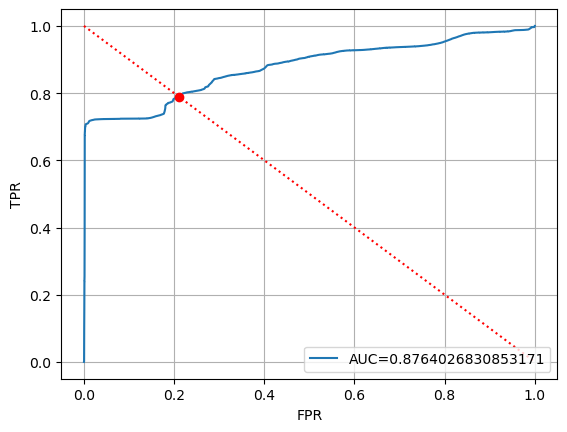

array([0.06749035], dtype=float32)

In [22]:
threshold = ROC(y_test,y_pred)
threshold

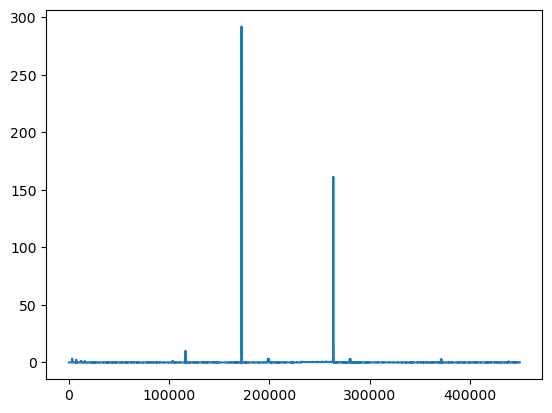

In [23]:
plt.plot(y_pred)

best: 0.27941176470588236 F1: 0.8160282923954024


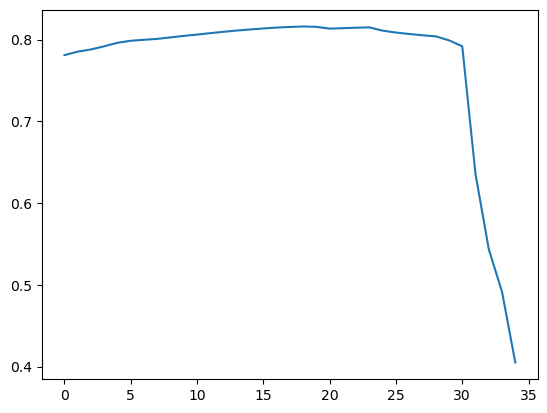

In [28]:
ff = 0
f_history = []
initial_y = 0.2
best = -1
for inc in np.linspace(0, 0.15, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

# Point Adjust

In [41]:
len(labels)

449855

In [42]:
len(y_pred)

449855

In [43]:
len(y_test)

449855

In [29]:
labels = labels[window_size:]
started = False
anomaly_segments = []
for i in range(len(labels)):
    if labels[i] == 1 and not started:
        started = True
        left_side = i
    if labels[i] == 0 and started:
        started = False
        anomaly_segments.append((left_side, i - 1))

## One point

best: 0.2375 F1: 0.8816803843432275


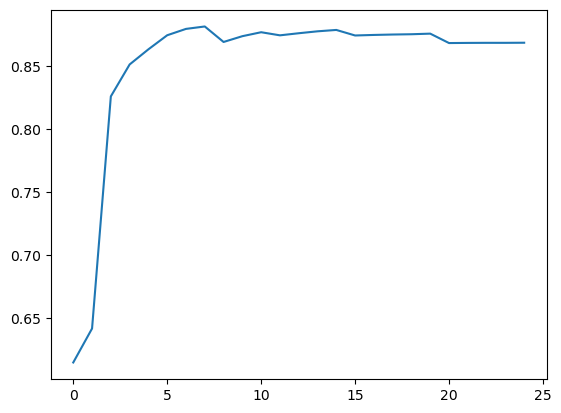

In [32]:
ff = 0
f_history = []
initial_y = 0.15
best = -1
for inc in np.linspace(0, 0.3, 25):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) > 0:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

## Point adjust 20%

best: 0.34375 F1: 0.8718936772569992


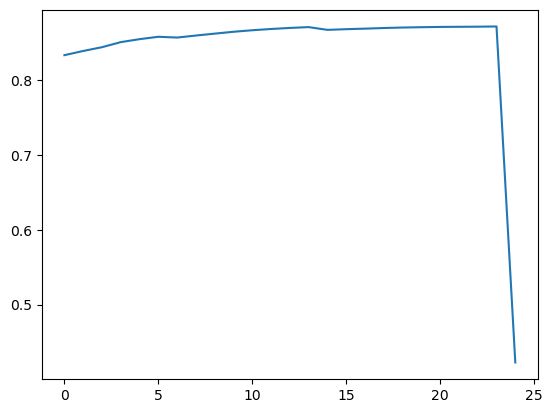

In [31]:
ff = 0
f_history = []
initial_y = 0.2
best = -1
for inc in np.linspace(0, 0.15, 25):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    for i, j in anomaly_segments:
        if np.sum(y_pred_int[i: j]) / (j - i) > 0.2:
            y_pred_int[i:j + 1] = [1 for _ in range(j - i + 1)]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc + initial_y
print(f'best: {best} F1: {ff}')
plt.plot(f_history)

In [26]:
# torch.save(AE1.state_dict(), 'GAE_77_Directed_200_epochs.pth')
# AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

In [27]:
# AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

In [28]:
# def testing(loader, alpha=.5, beta=.5):
#     results=[]
#     with torch.no_grad():
#         for batch in loader:
#             w1=AE1(batch)
#             results.append(torch.mean((batch-w1)**2, axis=1))
#     return results

# def get_threshold(val_loader):
#     recon_errors = testing(val_loader)
#     complete_vals = np.concatenate([torch.stack(recon_errors[:-1]).view(-1, num_nodes).detach().cpu().numpy(),
#                                     recon_errors[-1].view(-1, num_nodes).detach().cpu().numpy()])
#     return np.max(complete_vals, axis=0)

In [29]:
# thresholds = get_threshold(validation_loader)
# results=testing(test_loader, alpha=0.3, beta=0.7)
# y_pred=np.concatenate([torch.stack(results[:-1]).view(-1, num_nodes).detach().cpu().numpy(), 
#                        results[-1].view(-1, num_nodes).detach().cpu().numpy()])

In [30]:
# factor = 1

In [31]:
# factor = 720
# res = y_pred > (thresholds * factor)
# boo = np.any(res, axis = 1)
# verdicts = [1 if elem else 0 for elem in boo]
# conf_matrix = confusion_matrix(y_test, verdicts)
# TP = conf_matrix[1, 1]
# TN = conf_matrix[0, 0]
# FP = conf_matrix[0, 1]
# FN = conf_matrix[1, 0]
# F1 = f1_score(y_test, verdicts)
# precision = precision_score(y_test, verdicts)
# recall = recall_score(y_test, verdicts)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", F1)
# print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')
# print(f'Factor is: {factor}')

In [32]:
sum(p.numel() for p in AE1.parameters() if p.requires_grad)

6680912